# Setup

In [19]:
import pickle,gzip,math,os,time,shutil,torch,random,timm,torchvision,io,PIL
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torchvision import transforms
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder
from fastcore.foundation import L, store_attr

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

In [20]:
# Image URLs for demos. Change as desired.
face_url = "https://images.pexels.com/photos/2690323/pexels-photo-2690323.jpeg?w=256"
spiderweb_url = "https://images.pexels.com/photos/34225/spider-web-with-water-beads-network-dewdrop.jpg?w=256"

# Loading Images

In [42]:
def download_image(url):
    imgb = fc.urlread(url, decode=False) 
    return torchvision.io.decode_image(tensor(list(imgb), dtype=torch.uint8)).float()/255.

In [46]:
torchvision.__version__

'0.14.1'

In [47]:
content_im = download_image(face_url).to(def_device)
print('content_im.shape:', content_im.shape)
show_image(content_im);

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xff in position 0: invalid start byte

In [ ]:
content_im.min(),content_im.max() # Check bounds

# Optimizing Images

GOAL: We want to make the image to continue to look like that lady,
and change the style to match the style of another picture.
In the optimization loop, each step will be moving the style closer.
We loop through steps of a optimization loop (not thru different images).

We don't have a dataset with training examples. 
We just have a single target and a single thing we're optimizing.
We define a `LengthDataset()` class to follow the dataset standard, with `__getitem__` and `__len__`. 
But for `__getitem__` it returns 0 0, as we do not care about the content from this dataset.
We just need something that we can pass to the learner to do a number of training iterations.
We define a fake dummy dataloaders `get_dummy_dls(length=100)` with a hundred items.
It creates the dataloaders and gives us a way to train for a number of steps.

In [10]:
class LengthDataset():
    def __init__(self, length=1): self.length=length
    def __len__(self): return self.length
    def __getitem__(self, idx): return 0,0

def get_dummy_dls(length=100):
    return DataLoaders(DataLoader(LengthDataset(length), batch_size=1), # Train
                       DataLoader(LengthDataset(1), batch_size=1))      # Valid (length 1)

We define a `TensorModel` `Module` class which just has a tensor `t` as its parameter.
There is no actual neural network.
We are just going to pass in a random image or some image shaped tensor, with a set of numbers that we can optimize.
<br>
Putting something in an `nn.Parameter` doesn't change it in any way, it is just a normal tensor, 
but it is stored inside the Module as being a tensor to optimize.
We're not optimizing a model, we're optimizing the pixels of an image directly.
Because it's in a parameter if we look at it e.g., `model.t` it does `require_grad` as that's already set up because the `nn.Module` 
is going to look for any parameters.

The shape of the parameters that we're optimizing is the same shape as the image.
That tensor will be optimized if we pass it into a learner fit method.
This model has an argument (`x=0`) passed to forward, which we ignore.
We just make it easier ourselves by making the model look the way our learner expects.

In [23]:
class TensorModel(nn.Module):
    def __init__(self, t):
        super().__init__()
        self.t = nn.Parameter(t.clone())
    def forward(self, x=0): return self.t

In [24]:
model = TensorModel(torch.rand_like(content_im))
show_image(model());

NameError: name 'content_im' is not defined

In [ ]:
[p.shape for p in model.parameters()]

Alternatively, we could use e.g. `TrainCB`, set it up with a custom `predict` method that 
calls the model forward method with no parameters, calling the loss function on just the predictions.
But if we want to skip this, as we take `x=0` and never use it.
That should also work without this callback, either way is fine.
It is a nice approach if you already have an existing model which expects some number of parameters,
just modify the `TrainCB` callback, but we don't need to in this case.

Let's put this in a Learner, let's optimize it with some loss function.
To clarify the `get_loss` had to change because normally we pass a Target to the loss function.
Let's learn our grids and then `learn.batch`.
We could remove that if we wanted to have the loss function take a target that we then ignore.

We build on the idea of modifying the training callback in the ddpm example.
In `ImageOptCB` it is a 2 lines change.
To get our model predictions `preds` we call the `forward` method which returns an image that we're optimizing.
We evaluate this according to a loss function that just takes in an image.

In [ ]:
class ImageOptCB(TrainCB):
    def predict(self, learn): learn.preds = learn.model()
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds)

For the first loss function `loss_fn_mse` we use Mean Squared Error between the image that we are generating (output of the model)
and the content image that is our target.

In [ ]:
def loss_fn_mse(im):
    return F.mse_loss(im, content_im)

We set up our model and start it with a random image like the one above.
We create a learner with a dummy dataloader for 100 steps, `loss_fn_mes` as the loss function, an `lr` and  `optim.Adam`.
(default optimizer probably works fine).
We run it and the loss goes from a non-zero number to close to zero.

In [ ]:
model = TensorModel(torch.rand_like(content_im))
cbs = [ImageOptCB(), ProgressCB(), MetricsCB(), DeviceCB()]
learn = Learner(model, get_dummy_dls(100), loss_fn_mse, 
                lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1)

We look at the final result (call learn.model) and show it as an image and compare it with the source input image.
They look identical.

In [ ]:
# Result (left) vs target image (right):
show_images([learn.model().clip(0, 1), content_im]);

JH: To clarify this "pointless" example, where we started with a noisy image and used SGD to make the pixels get closer 
to the source image (lady in the sunglasses).
This is just to show that we can turn noisy pixels into something else by having it follow a loss function.
And this loss function makes the pixels look as the source image.
It's a very simple loss a one Direction that you update, almost trivial to solve.
It helps us get the framework in place.

## Viewing progress

Just seeing that result is not instructive.. maybe is a bug in the code that just duplicated the image.
We need a way of observing progress. 
We define a login callback `ImageLogCB` that after every batch stores the output as an image.
Every `log_every` iterations it's going to append the current image in a list, to be shown after the training.
All else is as before but passing in `ImageLogCB` callback it will show the progress.

In [ ]:
class ImageLogCB(Callback):
    order = ProgressCB.order + 1
    def __init__(self, log_every=10): store_attr(); self.images=[]; self.i=0
    def after_batch(self, learn): 
        if self.i%self.log_every == 0: self.images.append(to_cpu(learn.preds.clip(0, 1)))
        self.i += 1
    def after_fit(self, learn): show_images(self.images)

Starting from noise after a few iterations already most noise is gone.
By the end it looks exactly like the content image.
<br>
We have the infrastructure in place to create a variety of interesting outputs, e.g., artistic, 
image reconstruction, super resolution, colorization, etc.
We just have to modify the loss function and we first created the easiest, checked it before we start doing fancy stuff.
Now that is all in place, we will be able to visually see if things are going wrong, and we know what we need to modify.

It would be great if we could see what is happening over time. 
You could save individual images and turn them into a video, 
but for quick feedback we can also log images every few iterations and display them in a grid in `after_fit`:

In [ ]:
model = TensorModel(torch.rand_like(content_im))
learn = Learner(model, get_dummy_dls(150), loss_fn_mse, 
                lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(30)])

## Getting Features from VGG16

Maybe we want to match an image but also have a particular overall color, or something more complicated.
To get a richer measure of what the image looks like, we extract features  from a pre-trained network.
This is the core idea of this notebook: 
We feed in an image, and then have downsampling convolutions with Maxpooling until some final prediction.
<br>
JH: A big difference: that 7x7x512 nowadays we use Adaptive or Global pooling to get down to 1x1x512.
Vgg16 is unusual (by today's standards), it just flattens that out into a 1x1x4096.
This might be an interesting property. 
We should consider training resNets without global pooling and instead do flattening.
We don't do flattening because that very last linear layer from 1x1x4096 to 1x1x1000 is for an Imagenet model.
It is going to need a big weight Matrix, 4096x1000, hence very memory intensive for a poor performing model by modern standards.
But, doing that actually also has some some potential benefits.

We're going to peek inside a small CNN and extract the outputs of different layers.

### Load VGG network

![vgg diag](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

In [29]:
print(timm.list_models('*vgg*'))

['repvgg_a2', 'repvgg_b0', 'repvgg_b1', 'repvgg_b1g4', 'repvgg_b2', 'repvgg_b2g4', 'repvgg_b3', 'repvgg_b3g4', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']


Let's load the model, look at what the layers are and then in the next section
we can see what kinds of images work when we optimize towards different layers in there.
In the `vgg16` network we have convolutions, RELUs, Maxpooling, etc, all in one `nn.Sequential`.
It doesn't have the head so we said `.features` so this is the features subNetwork.
That's everything up until some point and then you have the flattening and the classification which we're throwing away.
This is the the body of the network and we're going to tag into various layers and extract the outputs.

In [31]:
vgg16 = timm.create_model('vgg16', pretrained=True).to(def_device).features

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/germangoldszmidt/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
# vgg16

### Normalize Images

This model was trained on a normalized version of Imagenet, using the dataset mean and std to normalize the images.
To match what the data looked like during training we need to match that normalization step.
We've done this on grayscale images where we just subtract the mean divide by the standard deviation.
But here these are 3 Channel RGB image, we can't get away with just subtract the mean and divide by the standard deviation.

This model expacts images normalized with the same stats as those used during training, which in this case requires the stats of the ImageNet dataset. 

In [32]:
imagenet_mean = tensor([0.485, 0.456, 0.406])
imagenet_std = tensor([0.229, 0.224, 0.225])

We now need to be more careful than we can with just a scalar value. 

In [35]:
# Try 1 (won't work):
#(content_im - imagenet_mean) / imagenet_std

With single-channel images normalizing is straightforward. With 3 channels, we must consider
the shapes and broadcasting rules.

The `imagenet_mean` has 3 values, one for each RGB channel.

In [36]:
imagenet_mean.shape

torch.Size([3])

The content image has 3 channels 256x256. 
If we just say `(content_im - imagenet_mean)` going from right to left and find the first non-unit axis.
Anything with a size > 1 it's going to try and line those up, in this case the 3 and the 256, which don't
match, so we get an error.
More perniciously if the shape did happen to match, it might not be what we intended.

In [37]:
content_im.shape

NameError: name 'content_im' is not defined

We want the 3 channels mapped to the 3 channels of the image and then somehow expand those values out across the two other dimensions.
For this, we add two additional dimensions with `None` on the right of the `imagenet.mean`.
Alternatively, we  could use `.unsqueeze(-1)` (twice?) but `None` is what we are using.
Now the shapes match, from right to left, if it is a unit Dimension size one it expands it out to match the other tensor.
If it is a non-unit dimension then the shapes must match.

With this reshaping operation we can write a `normalize(im)` to apply to the images.

In [ ]:
# Try 2:
def normalize(im):
    imagenet_mean = tensor([0.485, 0.456, 0.406])[:,None,None].to(im.device)
    imagenet_std = tensor([0.229, 0.224, 0.225])[:,None,None].to(im.device)
    return (im - imagenet_mean) / imagenet_std

We check their `min` and `max` to ensure that they make sense.

In [ ]:
normalize(content_im).min(), normalize(content_im).max()

We check the `mean` to ensure that it is somewhat close to zero.
Our Blue channel is brighter than the others and if we go back and look at our image it is.

In [ ]:
normalize(content_im).mean(dim=(1, 2))

As we've implemented it, we can use `torchvision.transforms.Normalize`.
We pass the mean and standard deviation `std` to it and it ensures that the devices and shapes match.

In [ ]:
# And with torchvision transforms:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

The Min, Max and Means are the same, i.e., our function does the same as the torchvision normalized transform.

In [ ]:
normalize(content_im).min(), normalize(content_im).max(), normalize(content_im).mean(dim=(1, 2))

### Get intermediate representations, take 1:

We want to feed some data through the network, storing the outputs of different layers. Here's one way to do this:

To extract the features from this network we are going to normalize our inputs `imgs`, 
and run through each `layer` in the sequential stack.
We pass the result of the layer `x` through each layer.
If we're in one of the special `target_layers`, append the outputs of that layer to a list `feats`.
The term *features* here means the activations of a layer, in this case two particular layers 18 and 25.

In [48]:
def calc_features(imgs, target_layers=(18, 25)): 
    x = normalize(imgs)
    feats = []
    for i, layer in enumerate(vgg16[:max(target_layers)+1]):
        x = layer(x)
        if i in target_layers:
            feats.append(x.clone())
    return feats

<mark> NB: There's a problem (Python?/Pytorch?) using a list as a default, so we should use tuples.
When we use a mutable type like a list in a python default parameter it keeps it around.
And if we change it later then it modifies the function.
Suggest never using a list as a default parameter because at some point it will create weird problems.
    </mark>

In [49]:
# Testing it out to see the shapes of the resulting feature maps for the 18 and 25 layers:
feats = calc_features(content_im)
[f.shape for f in feats]

NameError: name 'content_im' is not defined

**TODO Homework**: Do this using Hooks.

### What's the point?

You may remember us looking at [Feature visualization](https://distill.pub/2017/feature-visualization/) and talking about how deep CNNs 'learn' to classify images. Early layers tend to capture gradients and textures, while later layers more complex types of features. We exploit this complexity hierarchy for artistic purposes.
Being able to choose what kind of features to use when comparing images has a number of other useful applications. 

# Optimizing an Image with Content Loss

Let's start optimizing an image by comparing it's features (from two later layers) with those from the target image. If our theory is right, we should see the structure of the target emerge from the noise without necessarily seeing a perfect re-production of the target like we did in the previous MSE loss example.

We're feeding in an image that's 256x256 and the first layer that we're looking at is (18).
It's getting half to 128x128 then to 64x64, and 32x32x512.
(The ones in the VGG diagram are different sizes because they have a different starting size.)
Those are the features for layer 18, a tensor of shape 512x32x32.
For every spatial location in that 32x32 grid we have the output from 512 different filters, which 
are the "features" (ie channels in a single convolution).
We want to capture different concepts at different layers.
To get a feel for this we just compare these feature Maps, we institute a "Content loss" also called a "perceptual loss".
We focus on a couple of later layers we pass-in `target_im`, eg the content image,
and we calculate those features in those target layers.
In the `__call__` we compare to our inputs and calculate the features of our inputs 
and do the MSE between those and our target features.
<br>
`ContentLossToTarget` is a loss function which has a `__call__` method (a callable in Python).
(In a Module we call it forward but in normal Python it is `__call__`.)
It takes one input which is the way we set up the image training callback earlier.
It's just going to pass in the input `target_im` which is the image as it's been optimized to so far.
Initially it's going to be random noise, and then the loss we are calculating is the MSE
of how far away is `input_im` from the target image `target_im`.
The MSE for each of the layers (default 18 and 25).
It is a bit strange weird to call (eg 2) different neural network features,
not because that's the model we're optimizing, but because it's the loss function it's how far away are we.
If we SGD optimize that loss function we are not going to get the same pixels, 
we get pixels which have the same activations of those features.

In [ ]:
class ContentLossToTarget():
    def __init__(self, target_im, target_layers=(18, 25)):
        fc.store_attr()
        with torch.no_grad():
            self.target_features = calc_features(target_im, target_layers)
    def __call__(self, input_im): 
        return sum((f1-f2).pow(2).mean() for f1, f2 in 
               zip(calc_features(input_im, self.target_layers), self.target_features))

If we run it we can see the shape of the source image person, but it doesn't match on a color and style basis.
18 and 25 are fairly deep (there are 31 layers).
Color often doesn't have much of a semantic property, that may be why it doesn't care much about color.
E.g., it's still going to be an eyeball whether it is green or blue.

We aren't constraining the tensor that we're optimizing to be in the same bounds as a normal image
so some of these may also be <0  or >1. 
Almost hacking the ANN to get the same features that those deep layers have 
by passing in something that it's never seen during training.
For display we're clipping it to be an image,
But we may want to have either some sort of sigmoid function or some other way to clamp 
the tensor model and to have outputs that are within the allowed range.
Notice that the background hasn't changed much.
The reason for that would be that the VGG model we're using in the loss function was trained on Imagenet.
Imagenet is good at recognizing a single big object like a dog or a boat.
It's not going to care about the background, so the background 
isn't going to have much in the way of features at all.
That is why it hasn't changed the background yeah.


In [ ]:
loss_function_perceptual = ContentLossToTarget(content_im)
model = TensorModel(torch.rand_like(content_im))
learn = Learner(model, get_dummy_dls(150), loss_function_perceptual, 
                lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(log_every=30)])

Interesting to see how little it looks like the image, at the same time we can recognize it.
We can also try passing-in them earlier list right and comparing on those earlier layers and
we get a different result because now we're optimizing to some image that is a lot closer to the original.
Still it doesn't look the same, so there are a few things that are worth noting.
We're hooking into these RELU layers which might mean,
for example, that if we are looking at the very early layers we're missing out on some 
features that was one of my guesses as to why this didn't have as dark as the input image.
Also we might be going out of bounds to get the same kinds of features.

We can see how by looking at really deep layers we really don't care about the color or Texture.
We are just getting like sunglasses bits, and by looking at the earlier layers
we have a more rigid adherence to the the lower level features.
It gives us a tunable way to compare two images.
We can say do we care that they match exactly on pixels, then we can use MSE,
but if we care about the exact match then we can use some early layers.
If we only care about the overall semantics we can go to deeper layers and we can experiment with.

This is like the technique that Xyler and Fergus and the distilled papers use to identify what do filters look at. 
We can optimize an image to maximize a particular filter. 
For example that would be a similar loss function to the one we've built here.
Fun project: calculate these feature maps, pick one of the 512 features,
and optimize the image to maximize that activation.
By default we might quite a noisy weird result like almost an adversarial input.
"Feature Visualization" people add things like augmentations.
So we are optimizing an image that under some augmentations still activates that feature.


**Choosing the layers determines the kind of features that are important:**

In [ ]:
loss_function_perceptual = ContentLossToTarget(content_im, target_layers=(1, 6))
model = TensorModel(torch.rand_like(content_im))
learn = Learner(model, get_dummy_dls(150), loss_function_perceptual, 
                lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(log_every=30)])

We know how to optimize an image, how to extract features from this neural network.
This is for comparing, for different types of features how similar are two images.
For a full style transfer artistic application we need to keep the structure
of the source image, and have the style (eg., style, textures) come from a different image.
<br>
The feature maps have a spatial component.
For example, we had a 32x32x512 feature map, each location in the 32x32 grid correspond to some part of the input image.
If we just do MSE for the activations from some early layers, 
that would be asking for the same types of features in the same locations.
We want to get an image that matches the source image, with the same colors and textures,
but they may  be in different parts of the image, i.e., we want to get rid of the spatial aspect. 
For example,  give us the image in the style of Van Gogh Starry Night.
We're not asking where in the image there should be something with this texture,
just that the kinds of textures that are used anywhere in that image should
also appear in in our version, but not necessarily in the same place.
The solution that Seller? and Ferguson proposed uses a Gram Matrix.
We want some measure of what kinds of styles are present without worrying about where they are.

# Style Loss with Gram Matrix

REFERENCES:
Style transfer was first invented in the Gattys paper.
Seiler and Ferguson did the feature visualization.
Lets open the original paper and use Jono's explanation to understand the paper, which has some nice pictures. 
Gram Matrix inner product between the vectorized feature map, but it doesn't explain how the gram Matrix works.
People have used Gram Matrices in other contexts for similar kinds of measures.
Pytorch has named parameters, we can name layers of a sequential model.


We know how to extract feature maps. The next thing we'd like to do is find a way to capture the **style** of an input image, based on those early layers and the kinds of textural feature that they learn. Unfortunately, we can't just compare the feature maps from some early layers since these 'maps' encode information spatially - which we don't want!

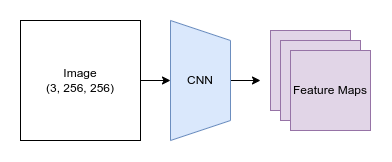

So, we need a way to measure what **kinds** of style features are present, and ideally which kinds occur together, without worrying about **where** these features occur in the image. 

Enter something called the Gram Matrix. The idea here is that we'll measure the **correlation** between features. Given a feature map with `f` features in an `h` x `w` grid, we'll flatten out the spatial component and then for every feature we'll take the dot product of that row with itself, giving an `f` x `f` matrix as the result. Each entry in this matrix quantifies how correlated the relevant pair of features are and how frequently they occur - exactly what we want. In this diagram each feature is represented as a colored dot.

It is difficult to represent more than two-dimensional things on a 2d grid.
The feature map has a height and width (eg 32x32), and a number of features (a 3rd dimension) represented as colored dots.
With a Gram Matrix we flatten out the spatial Dimension, reshape it to have the width times the height.
The spatial (features) dimension is on the horizontal (vertical) axis.
Each row (e.g, yellow) has a 1 if there is a corresponding (eg yellow) dot in the location else it gets a 0.
Once we flattened the feature map, we only care about which types of features we have and do they occur with each other.
We get the dot products of each row with all other rows.

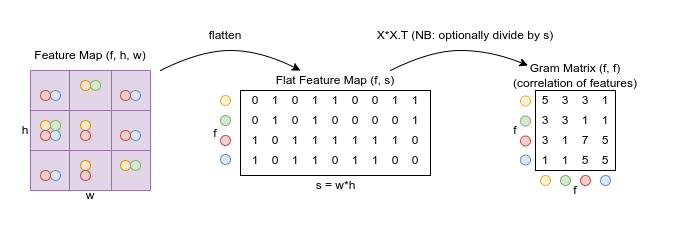

For these feature vectors how correlated are they with each other.
We end up with a Gram Matrix (correlation of features).
We can read this example as: there are 7 Reds in total, only one location red occurs alongside a green.
The Gram Matrix has no spatial component, it's just a feature Dimension by feature Dimension.
It is a measure of how common these features are (eg an uncommon one is green),
and how frequently they occur together with other features.

We implement this diagram in code, use 0 or 1 for simplicity, but we could have different size activations,
but not as easy to represent visually.

Re-creating the diagram operations in code:

In [ ]:
t = tensor([[0, 1, 0, 1, 1, 0, 0, 1, 1],
            [0, 1, 0, 1, 0, 0, 0, 0, 1],
            [1, 0, 1, 1, 1, 1, 1, 1, 0],
            [1, 0, 1, 1, 0, 1, 1, 0, 0]])

We do it with an einsum because it makes it easy to add later the (Bastion?) engine.
It is the Matrix multiplied with its own transpose, and doing it with `matmul` 
we get the same result, so that is the Gram Matrix calculation.
We can now use it to create a measure and when we look at things like word2Vic, it's got some similarities.
The idea of co-occurrence of features also reminds me of the clip loss.
It is a dot product with itself.

In [ ]:
torch.einsum('fs, gs -> fg', t, t)

In [ ]:
t.matmul(t.T) # Alternate approach

The idea of multiplying with your own transpose is a common mathematical technique, used 
in many areas, e.g., protein folding.
The difference in each case is the Matrix that we're multiplying by its own transpose.
For covariance the Matrix is the Matrix of differences to the mean.
In this case the matrix is the flattened picture.

### Trying it out

In [ ]:
style_im = download_image(spiderweb_url).to(def_device)
show_image(style_im);

The `calc_grams` will do that operation we did above, but we're going to add scaling,
because we have a feature map and we might pass in images of different sizes.
<br>
As there is a relation to the number of spatial locations, by scaling by this width times height
we get a relative measure as opposed to an absolute measure.
Hence the comparisons are going to be valid even for images of different sizes.
We have a `chw, dhw ->cd` (channels/features by height by width image).
we pass-in two versions of `x` because it's the same image in both times.
And we map this down to just features by features.
We can't repeat variables in einsum so that's why it is`c` and `d`.

In [ ]:
def calc_grams(img, target_layers=(1, 6, 11, 18, 25)):
    return L(torch.einsum('chw, dhw -> cd', x, x) / (x.shape[-2]*x.shape[-1]) # 'bchw, bdhw -> bcd' if batched
            for x in calc_features(img, target_layers))

We run this on our style image `style_im` and see we are targeting 5 different layers.

In [ ]:
style_grams = calc_grams(style_im)

For each one the first layer has 64 features and so we get a 64 by 164 gram Matrix.
The second one is 128 features so we can hit 128x128 gram Matrix, etc.

In [ ]:
[g.shape for g in style_grams] # The gram matrices for features from different layers

We use the `attrgot` method (it is a `fc.L` "magic list"), 
Let's use `StyleLosstoTarget()` as a loss just like with the content lost before,
we're going to take in a Target image which is going to be our style,
calculate the Gram matrices and when we get an input to our last function.

In [ ]:
style_grams.attrgot('shape') # The magic of fastcore's L

We calculate the Gram matrices for that and do the MSE between the gram matrices.
These have no spatial components just what features are there.
Comparing the two to make sure that they have the same kinds of features,
and the same kinds of correlations between features.

In [ ]:
class StyleLossToTarget():
    def __init__(self, target_im, target_layers=(1, 6, 11, 18, 25)):
        fc.store_attr()
        with torch.no_grad(): self.target_grams = calc_grams(target_im, target_layers)
    def __call__(self, input_im): 
        return sum((f1-f2).pow(2).mean() for f1, f2 in 
               zip(calc_grams(input_im, self.target_layers), self.target_grams))

In [ ]:
style_loss = StyleLossToTarget(style_im)

The content image `content_im` at the moment has a high loss when we compare it to our style image `style_im`.
That means the physical content image doesn't look anything like a spider web in terms of its textures, etc. 

In [ ]:
style_loss(content_im)

## Style Transfer

We set up an optimization. 
One difference is that now we are starting from the content image itself rather than optimizing from random noise.

We can choose either way. For style transfer it's nice to use the content image as a starting point.
At the beginning it just looks like our content image.
As we do more steps we maintain the structure, because we're using the content loss as one component of our loss function.
And we also have more of the style because at the early layers we're evaluating the style loss.
It doesn't have the same layout as the style image spider web, 
but it has the same kinds of textures and structures.
The final result has done our goal of taking one image and do it in the style of another.

In [ ]:
model = TensorModel(content_im) # Start from content image
style_loss = StyleLossToTarget(style_im)
content_loss = ContentLossToTarget(content_im)
def combined_loss(x):
    return style_loss(x) + content_loss(x)
learn = Learner(model, get_dummy_dls(150), combined_loss, lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(30)])

Notice that the spider web is nicely laid out, she's almost picking it out with her fingers,
and her face, very important in terms of object recognition, the model didn't mess with the face.
match at all so it's kept the spider webs away from that like I think it's the more you look at it the more
This is impressive how it's managed to find a way to add spider webs without messing up the
overall semantics of the image.

In [ ]:
show_image(learn.model().clip(0, 1)); # View the final result

And trying with random starting image, weighting the style loss lower, using different layers:

In [ ]:
model = TensorModel(torch.rand_like(content_im))
style_loss = StyleLossToTarget(style_im)
content_loss = ContentLossToTarget(content_im, target_layers=(6, 18, 25))
def combined_loss(x):
    return style_loss(x) * 0.2 + content_loss(x)
learn = Learner(model, get_dummy_dls(300), combined_loss, lr=5e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(60)])

TODO: find your own pictures and make sure not to steal someone's licensed work.
There's a lot of Creative Commons images to try bashing together.
Do it at a larger size, higher resolution style, etc.
There's so much to experiment with: for example change the content loss to focus on.
Maybe an earlier layer can start from a random image  instead of a content image.
Or we can start from the style image and optimize towards the content image.
We can change how we scale these two components of the loss function, how long to train for, the learning rate, etc. 
What you can optimize and what you can explore, get different results with
different scalings and different focus layers...
There is a lot of fun experimentation to finding a set of parameters that give 
a pleasent result for a given style content pair, and for a given effect on the output.

## For Comparison: non-miniai version

On the experimentation version, we're doing all this work setting up these callbacks,
and isn't it nicer to just have here's my image that I'm optimizing, 
set up an Optimizer, a loss function, and an optimization Loop.
It is easier when we want to do it once.
In a tutorial we keep it as minimal as possible, just show what style loss is...
But when we want to try it again, adding a different layer, add some progress, etc., it gets messy quickly.
As soon as we want to save images for a video and mess with the loss function,
do some sort of annealing on the learning rate, ....
Each of these things is going to grow this loop into something messier.
It was fun to quickly  convert to being able to experiment with a completely new version 
with minimal lines of code, minimal changes, 
having everything in its own piece like the the image logging.
Or to make a movie showing the progress that goes in a separate callback.
To tweak the model we're just tweaking one thing, 
all the other infrastructure can stay the same.

In [ ]:
# The image to be optimized
im = torch.rand(3, 256, 256).to(def_device)
im.requires_grad = True

# Set up the optimizer
opt = torch.optim.Adam([im], lr=5e-2)

# Define the loss function
style_loss = StyleLossToTarget(style_im)
content_loss = ContentLossToTarget(content_im, target_layers=[6, 18, 25])
def combined_loss(x):
    return style_loss(x) * 0.2 + content_loss(x)

# Optimization loop
for i in range(300):
    loss = combined_loss(im)
    loss.backward()
    opt.step()
    opt.zero_grad()
    
# Show the result
show_image(im.clip(0, 1));

## Comments
T: May be worthwhile to play with other (non VGG) networks, as some special properties of VGG
that are good for style transfer.
There are papers that explore how to use other networks for style transfer that maintain some of the properties of VGG.
Explore these papers, and use the framework that allows us to Plug and Play different networks.

JH: taking a convnet or a resnet, replacing its head with a VGG head would be interesting to try.
On the experimentation version, we're doing all this work setting up these callbacks,
and isn't it nicer to just have here's my image that I'm optimizing, 
set up an Optimizer, a loss function, and an optimization Loop.

It is easier when we want to do it once.
In a tutorial we keep it as minimal as possible, just show what style loss is...
But when we want to try it again, adding a different layer, show progress, save images for a video,
change the loss function, annealing on the learning rate, etc., the training loop gets messy quickly.
With miniAI it was fast to experiment with a completely new version with minimal lines of code, minimal changes, 
having everything in its own piece like the the image logging.
To tweak the model we touch one thing and the other infrastructure can stay the same.

JH: When using the fastAI library people jump straight into Data blocks.
But they may be working on a custom thing where there isn't a data block already written for.
Step One is lets write a data block, and that's not easy.
Would be better to focus on building a model.
JH tells people to go down a layer of abstraction.
JH doesn't often start at the lowest level of abstraction, because he does not do it right, e.g., forget zero_grad.
Easier to mess up something, especially when trying to have it run quick.
So he starts at a reasonably low level, but not the lowest.
<br>
With miniAI we understand all the (few) layers. 
We could write our own e.g., trainCB, and it ensures to use torch.nograd, and to put it in a Val mode, etc.,
and it will be done correctly.
We can run a learning rate finder, run on Cuda, etc.
We can have "our own"  framework where there are multiple ways of doing the same thing.
For example, Jonna showed with the imageOptCB callback can be implemented in different ways.

Using these pre-trained networks as smart feature extractors is powerful.
Unlike the "fun crazy" example that we're going to look at, they also have very valid uses.
For example, for super resolution or even something like difusion,
adding in a perceptual loss or even a style loss to the target image can improve things. 
We've played around with using perceptual loss for diffusion, 
or even to generate an image that matches a face, image to image with stable diffusion.
Maybe you have an extra guidance function that makes sure that structurally it matches 
is but maybe it actually doesn't.
Maybe you want to pass in a style image and have that guide the diffusion process 
to be a particular style without having to say the style name.
For many image to image tasks, using the features from a network like vgg 
has many practical uses apart from artistic.

What do you think are some pros and cons? How would this look once we start displaying progress, testing different configurations and so on?